<a href="https://colab.research.google.com/github/nh0875/Me/blob/main/RL2_Hilliard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Reinforcement Learning aplicado a Ta-Te-Ti
En este cuaderno desarrollo un entorno tipo *grid-world* para el juego Ta-Te-Ti y distintos métodos de aprendizaje por refuerzo para resolverlo. Cada subsección aborda los puntos 2.1 a 2.5 solicitados.

## 2.1 Definición del entorno Ta-Te-Ti
- **Espacio de estados (observaciones)**: vector de longitud 9 con valores `{0, 1, -1}` indicando casilleros vacíos, agente (X) u oponente (O). Se puede reestructurar en una grilla 3×3 para visualizarlo.
- **Estado inicial**: tablero vacío (`0`) y turno del agente.
- **Acciones**: índice entero de 0 a 8 que representa el casillero donde el agente quiere colocar su ficha. Se restringe a casilleros vacíos.
- **Transición**: tras la acción válida del agente se revisa si hay victoria o empate. Si el juego continúa, el entorno ejecuta la jugada del oponente (política aleatoria con preferencia por el centro).
- **Recompensas**: `+1` por victoria del agente, `-1` por derrota, `0` por empate, `-0.1` por acción inválida.
- **Condición de finalización**: victoria de alguno de los jugadores, empate o acción inválida.
- **Observaciones adicionales**: se provee una máscara de acciones válidas para facilitar el enmascaramiento en métodos tabulares y DQN.
Este formalismo permite usar algoritmos de RL estándar y analizar estrategias en un juego discreto conocido.

In [ ]:
"""Definiciones del entorno Ta-Te-Ti y heurísticas auxiliares."""
import numpy as np
from typing import Callable, Dict, List, Tuple, Union

SYMBOLS = {1: "X", -1: "O", 0: "·"}

def check_winner(board: np.ndarray, player: int) -> bool:
    """Devuelve True si el jugador indicado completa una línea en el tablero."""
    lines = []
    lines.extend(board)
    lines.extend(board.T)
    lines.append(np.diag(board))
    lines.append(np.diag(np.fliplr(board)))
    return any(np.all(line == player) for line in lines)

def board_full(board: np.ndarray) -> bool:
    """Indica si no quedan casilleros libres."""
    return not np.any(board == 0)

def minimax_best_action(board: np.ndarray, player: int = -1) -> int:
    """Calcula la mejor acción posible asumiendo juego perfecto mediante minimax puro."""

    def _minimax(b: np.ndarray, current: int):
        if check_winner(b, 1):
            return None, 1
        if check_winner(b, -1):
            return None, -1
        if board_full(b):
            return None, 0

        available = np.where(b.flatten() == 0)[0]
        if current == 1:
            best_score = -np.inf
            best_action = None
            for action in available:
                row, col = divmod(action, 3)
                b[row, col] = current
                _, score = _minimax(b, -current)
                b[row, col] = 0
                if score > best_score:
                    best_score = score
                    best_action = action
            return best_action, best_score
        best_score = np.inf
        best_action = None
        for action in available:
            row, col = divmod(action, 3)
            b[row, col] = current
            _, score = _minimax(b, -current)
            b[row, col] = 0
            if score < best_score:
                best_score = score
                best_action = action
        return best_action, best_score

    action, _ = _minimax(board.copy(), player)
    if action is None:
        valid = np.where(board.flatten() == 0)[0]
        return int(valid[0]) if valid.size else 0
    return int(action)

class TicTacToeEnv:
    """Entorno en estilo Gym que modela Ta-Te-Ti para experimentos de RL."""

    def __init__(self, opponent: Union[str, Callable[[np.ndarray, np.ndarray], int]] = "heuristic"):
        self.opponent = opponent
        self.current_player = 1
        self.board = np.zeros((3, 3), dtype=int)

    def reset(self) -> np.ndarray:
        """Limpia el tablero y devuelve la observación inicial."""
        self.board[:] = 0
        self.current_player = 1
        return self._get_obs()

    def _get_obs(self) -> np.ndarray:
        """Devuelve el estado plano de longitud 9."""
        return self.board.flatten().astype(int)

    def action_mask(self) -> np.ndarray:
        """Entrega una máscara binaria que marca los casilleros disponibles."""
        return (self.board.flatten() == 0).astype(int)

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, Dict]:
        """Aplica la jugada del agente, ejecuta la respuesta del oponente y entrega la transición."""
        info = {}
        if action < 0 or action >= 9 or self.board.flatten()[action] != 0:
            return self._get_obs(), -0.1, True, {"reason": "invalid_action"}

        row, col = divmod(action, 3)
        self.board[row, col] = 1
        if check_winner(self.board, 1):
            return self._get_obs(), 1.0, True, info

        if board_full(self.board):
            return self._get_obs(), 0.0, True, info

        self._opponent_play()
        if check_winner(self.board, -1):
            return self._get_obs(), -1.0, True, info

        if board_full(self.board):
            return self._get_obs(), 0.0, True, info

        return self._get_obs(), -0.01, False, info

    def _opponent_play(self) -> None:
        """Permite que el oponente (heurístico, minimax o callable) coloque su ficha."""
        mask = self.action_mask()
        valid_actions = np.where(mask == 1)[0]
        if valid_actions.size == 0:
            return

        if callable(self.opponent):
            state = self._get_obs()
            action = int(self.opponent(state, mask))
            if action not in valid_actions:
                action = int(np.random.choice(valid_actions))
        elif self.opponent == "heuristic":
            action = self._heuristic_action(valid_actions)
        elif self.opponent == "minimax":
            action = minimax_best_action(self.board)
        else:
            action = int(np.random.choice(valid_actions))

        row, col = divmod(action, 3)
        self.board[row, col] = -1

    def _heuristic_action(self, valid_actions: np.ndarray) -> int:
        """Oponente O: centro, esquinas y luego laterales."""
        preferences = [4, 0, 2, 6, 8, 1, 3, 5, 7]
        for pref in preferences:
            if pref in valid_actions:
                return pref
        return int(np.random.choice(valid_actions))

    def render(self) -> None:
        """Imprime el tablero en consola usando símbolos legibles."""
        grid = [[SYMBOLS[val] for val in row] for row in self.board]
        for row in grid:
            print(" ".join(row))

In [ ]:
env = TicTacToeEnv()
state = env.reset()
print("Estado inicial:", state)
print("Máscara de acciones válidas:", env.action_mask())
env.render()

Estado inicial: [0 0 0 0 0 0 0 0 0]
Máscara de acciones válidas: [1 1 1 1 1 1 1 1 1]
· · ·
· · ·
· · ·


## 2.2 Visualización de la política
La función `plot_policy_for_state` toma un mapeo `estado → acción` y lo dibuja sobre el tablero actual. Para cada celda muestra la marca existente y resalta la casilla que la política selecciona. Esto permite comparar diferentes políticas en situaciones concretas del juego.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_policy_for_state(policy: Dict[str, int], state: np.ndarray, title: str = "Política") -> None:
    """Visualiza sobre el tablero la acción elegida por una política para un estado dado."""
    key = tuple(state.tolist())
    action = policy.get(key, None)
    grid = state.reshape(3, 3)
    data = np.full((3, 3), np.nan)
    if action is not None and state[action] == 0:
        row, col = divmod(action, 3)
        data[row, col] = 1

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.heatmap(data, annot=False, cmap="YlGnBu", cbar=False, square=True, linewidths=1, linecolor="black", ax=ax)
    for i in range(3):
        for j in range(3):
            val = grid[i, j]
            if val == 1:
                ax.text(j + 0.5, i + 0.5, "X", ha="center", va="center", fontsize=14)
            elif val == -1:
                ax.text(j + 0.5, i + 0.5, "O", ha="center", va="center", fontsize=14)
            elif action is not None and (i, j) == divmod(action, 3):
                ax.text(j + 0.5, i + 0.5, "→", ha="center", va="center", fontsize=14, color="darkgreen")
            else:
                ax.text(j + 0.5, i + 0.5, "·", ha="center", va="center", fontsize=10, color="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.show()

## 2.3 Entrenamiento de políticas
En esta sección comparo tres enfoques:
1. **Política aleatoria**: no aprende, sirve como referencia mínima de desempeño.
2. **Q-Learning tabular**: usa una tabla `estado → acción` y estrategias ε-greedy.
3. **Deep Q-Network (DQN)**: aproxima la función Q con una red neuronal pequeña y experiencia replay.

In [ ]:
from collections import defaultdict, deque, namedtuple
import random

def state_to_key(state: np.ndarray) -> Tuple[int, ...]:
    """Convierte un estado plano en tupla hashable para indexar tablas."""
    return tuple(int(x) for x in state)

def random_policy(state: np.ndarray, mask: np.ndarray) -> int:
    """Selecciona uniformemente entre las acciones válidas."""
    valid = np.where(mask == 1)[0]
    return int(np.random.choice(valid)) if valid.size else 0

def masked_argmax(values: np.ndarray, mask: np.ndarray) -> int:
    """Devuelve el argmax restringido solo a casilleros disponibles."""
    masked_values = np.where(mask == 1, values, -np.inf)
    return int(np.argmax(masked_values))

def evaluate_policy(env: TicTacToeEnv, policy_fn, episodes: int = 1000) -> Dict[str, float]:
    """Evalúa una política y devuelve métricas de desempeño agregadas."""
    results = {"wins": 0, "losses": 0, "draws": 0, "invalid": 0, "rewards": []}
    for _ in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0.0
        while not done:
            mask = env.action_mask()
            action = policy_fn(state, mask)
            next_state, reward, done, info = env.step(action)
            ep_reward += reward
            state = next_state
            if done and info.get("reason") == "invalid_action":
                results["invalid"] += 1
        results["rewards"].append(ep_reward)
        if reward == 1.0:
            results["wins"] += 1
        elif reward == -1.0:
            results["losses"] += 1
        else:
            results["draws"] += 1
    total = episodes
    results["win_rate"] = results["wins"] / total
    results["loss_rate"] = results["losses"] / total
    results["draw_rate"] = results["draws"] / total
    results["avg_reward"] = float(np.mean(results["rewards"]))
    return results

def train_q_learning(env: TicTacToeEnv, episodes: int = 20000, alpha: float = 0.2, gamma: float = 0.99, epsilon: float = 1.0, min_epsilon: float = 0.05, decay: float = 0.999) -> Dict[str, np.ndarray]:
    """Entrena Q-Learning tabular con política epsilon-greedy y máscara de acciones."""
    q_table = defaultdict(lambda: np.zeros(9))
    epsilon_value = epsilon
    for ep in range(episodes):
        state = env.reset()
        done = False
        while not done:
            mask = env.action_mask()
            key = state_to_key(state)
            if np.random.rand() < epsilon_value:
                action = random_policy(state, mask)
            else:
                action = masked_argmax(q_table[key], mask)
            next_state, reward, done, _ = env.step(action)
            next_key = state_to_key(next_state)
            next_mask = env.action_mask()
            target = reward
            if not done:
                future = np.max(np.where(next_mask == 1, q_table[next_key], -np.inf))
                if not np.isfinite(future):
                    future = 0.0
                target += gamma * future
            q_table[key][action] += alpha * (target - q_table[key][action])
            state = next_state
        epsilon_value = max(min_epsilon, epsilon_value * decay)
    return q_table

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done", "mask"])

class ReplayBuffer:
    """Almacén FIFO para muestreo de transiciones en DQN."""

    def __init__(self, capacity: int = 5000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args) -> None:
        self.buffer.append(Transition(*args))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self) -> int:
        return len(self.buffer)

class QNetwork(nn.Module):
    """Pequeña red totalmente conectada para aproximar Q(s, a)."""

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 9)
        )

    def forward(self, x):
        return self.model(x)

def train_dqn(env: TicTacToeEnv, episodes: int = 12000, batch_size: int = 64, gamma: float = 0.99,
              lr: float = 1e-3, epsilon: float = 1.0, min_epsilon: float = 0.05, decay: float = 0.999) -> Dict:
    """Entrena un DQN clásico con red gemela, replay buffer y enmascaramiento de acciones."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net = QNetwork().to(device)
    target_net = QNetwork().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = ReplayBuffer(capacity=8000)
    epsilon_value = epsilon
    update_target_every = 200

    def epsilon_greedy(state_np: np.ndarray, mask: np.ndarray) -> int:
        if np.random.rand() < epsilon_value:
            return random_policy(state_np, mask)
        with torch.no_grad():
            state_tensor = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)
            q_values = policy_net(state_tensor).cpu().numpy().squeeze()
        q_values[mask == 0] = -np.inf
        return int(np.argmax(q_values))

    steps = 0
    losses = []
    for ep in range(episodes):
        state = env.reset()
        done = False
        while not done:
            mask = env.action_mask()
            action = epsilon_greedy(state, mask)
            next_state, reward, done, _ = env.step(action)
            next_mask = env.action_mask()
            buffer.push(state, action, reward, next_state, done, next_mask)
            state = next_state
            steps += 1

            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                state_batch = torch.tensor(batch.state, dtype=torch.float32, device=device)
                action_batch = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
                reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
                next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32, device=device)
                done_batch = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)
                mask_batch = torch.tensor(batch.mask, dtype=torch.float32, device=device)

                q_values = policy_net(state_batch).gather(1, action_batch)
                with torch.no_grad():
                    next_q = target_net(next_state_batch)
                    next_q[mask_batch == 0] = -1e9
                    max_next_q, _ = next_q.max(dim=1, keepdim=True)
                    target = reward_batch + gamma * (1 - done_batch) * max_next_q

                loss = nn.MSELoss()(q_values, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            if steps % update_target_every == 0:
                target_net.load_state_dict(policy_net.state_dict())

        epsilon_value = max(min_epsilon, epsilon_value * decay)

    return {
        "policy_net": policy_net,
        "target_net": target_net,
        "buffer": buffer,
        "losses": losses,
        "device": device
    }

In [ ]:
# Semillas para reproducibilidad en evaluaciones y entrenamiento.
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Evaluación de la política aleatoria vs oponente heurístico.
env_random = TicTacToeEnv()
random_results = evaluate_policy(env_random, random_policy, episodes=1000)

# Entrenamiento y evaluación de Q-Learning tabular.
env_q = TicTacToeEnv()
q_table = train_q_learning(env_q, episodes=15000, alpha=0.2, gamma=0.95, epsilon=1.0, min_epsilon=0.05, decay=0.995)

def q_policy(state: np.ndarray, mask: np.ndarray) -> int:
    """Selecciona la acción con mayor valor Q válida para el estado dado."""
    key = state_to_key(state)
    values = q_table[key].copy()
    values[mask == 0] = -np.inf
    if np.all(mask == 0):
        return 0
    return int(np.argmax(values))

q_results = evaluate_policy(TicTacToeEnv(), q_policy, episodes=1000)

# Entrenamiento y evaluación de la política basada en DQN.
env_dqn = TicTacToeEnv()
dqn_artifacts = train_dqn(env_dqn, episodes=9000, batch_size=64, gamma=0.95, lr=1e-3, epsilon=1.0, min_epsilon=0.05, decay=0.995)
policy_net = dqn_artifacts["policy_net"]
device = dqn_artifacts["device"]

def dqn_policy(state: np.ndarray, mask: np.ndarray) -> int:
    """Usa la red entrenada para devolver la acción válida con mayor valor Q."""
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = policy_net(state_tensor).cpu().numpy().squeeze()
    q_values[mask == 0] = -np.inf
    if np.all(mask == 0):
        return 0
    return int(np.argmax(q_values))

dqn_results = evaluate_policy(TicTacToeEnv(), dqn_policy, episodes=1000)

/tmp/ipython-input-1756881041.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state_batch = torch.tensor(batch.state, dtype=torch.float32, device=device)


In [ ]:
import pandas as pd

# Tabla de comparación frente al oponente heurístico: tasas y recompensa media.
comparison_df = pd.DataFrame([
    {"política": "Aleatoria", **{k: v for k, v in random_results.items() if k in ["win_rate", "loss_rate", "draw_rate", "avg_reward"]}},
    {"política": "Q-Learning", **{k: v for k, v in q_results.items() if k in ["win_rate", "loss_rate", "draw_rate", "avg_reward"]}},
    {"política": "DQN", **{k: v for k, v in dqn_results.items() if k in ["win_rate", "loss_rate", "draw_rate", "avg_reward"]}}
])
comparison_df

,política,win_rate,loss_rate,draw_rate,avg_reward
0,Aleatoria,0.353,0.593,0.054,-0.26878
1,Q-Learning,1.000,0.000,0.000,0.98000
2,DQN,1.000,0.000,0.000,0.98000


In [ ]:
# Re-evaluación de las tres políticas frente a un oponente minimax óptimo.
env_random_minimax = TicTacToeEnv(opponent="minimax")
random_minimax_results = evaluate_policy(env_random_minimax, random_policy, episodes=500)

env_q_minimax = TicTacToeEnv(opponent="minimax")
q_minimax_results = evaluate_policy(env_q_minimax, q_policy, episodes=500)

env_dqn_minimax = TicTacToeEnv(opponent="minimax")
dqn_minimax_results = evaluate_policy(env_dqn_minimax, dqn_policy, episodes=500)

comparison_minimax_df = pd.DataFrame([
    {"política": "Aleatoria", **{k: v for k, v in random_minimax_results.items() if k in ["win_rate", "loss_rate", "draw_rate", "avg_reward"]}},
    {"política": "Q-Learning", **{k: v for k, v in q_minimax_results.items() if k in ["win_rate", "loss_rate", "draw_rate", "avg_reward"]}},
    {"política": "DQN", **{k: v for k, v in dqn_minimax_results.items() if k in ["win_rate", "loss_rate", "draw_rate", "avg_reward"]}}
])
comparison_minimax_df

,política,win_rate,loss_rate,draw_rate,avg_reward
0,Aleatoria,0.0,0.79,0.21,-0.81798
1,Q-Learning,0.0,1.00,0.00,-1.03000
2,DQN,0.0,1.00,0.00,-1.03000


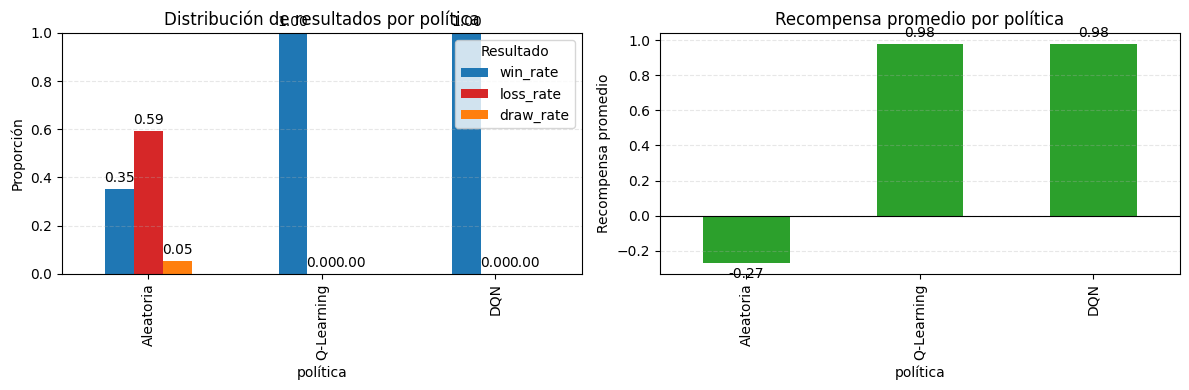

In [ ]:
# Visualización de desempeño frente al oponente heurístico.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
rates = comparison_df.set_index("política")["win_rate loss_rate draw_rate".split()]
rates.plot(kind="bar", ax=axes[0], color=["#1f77b4", "#d62728", "#ff7f0e"])
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Proporción")
axes[0].set_title("Distribución de resultados por política")
axes[0].legend(title="Resultado", loc="upper right")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)

avg_reward = comparison_df.set_index("política")["avg_reward"]
avg_reward.plot(kind="bar", ax=axes[1], color="#2ca02c")
axes[1].set_ylabel("Recompensa promedio")
axes[1].set_title("Recompensa promedio por política")
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].grid(axis="y", linestyle="--", alpha=0.3)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", padding=3)
axes[1].bar_label(axes[1].containers[0], fmt="%.2f", padding=3)

plt.tight_layout()
plt.show()

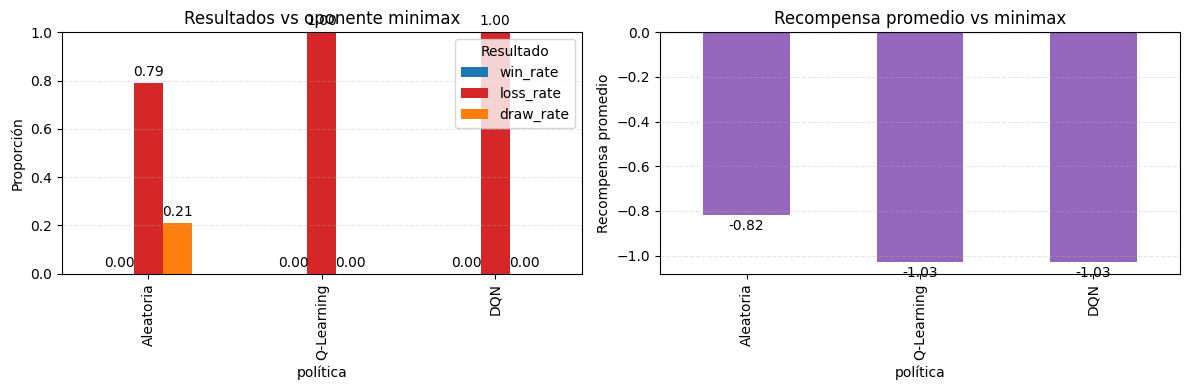

In [ ]:
# Visualización del enfrentamiento contra el oponente minimax.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
minimax_rates = comparison_minimax_df.set_index("política")["win_rate loss_rate draw_rate".split()]
minimax_rates.plot(kind="bar", ax=axes[0], color=["#1f77b4", "#d62728", "#ff7f0e"])
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Proporción")
axes[0].set_title("Resultados vs oponente minimax")
axes[0].legend(title="Resultado", loc="upper right")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)

minimax_rewards = comparison_minimax_df.set_index("política")["avg_reward"]
minimax_rewards.plot(kind="bar", ax=axes[1], color="#9467bd")
axes[1].set_ylabel("Recompensa promedio")
axes[1].set_title("Recompensa promedio vs minimax")
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].grid(axis="y", linestyle="--", alpha=0.3)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", padding=3)
axes[1].bar_label(axes[1].containers[0], fmt="%.2f", padding=3)

plt.tight_layout()
plt.show()

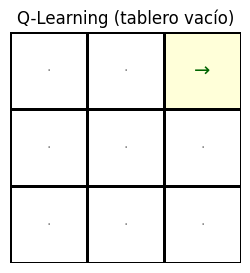

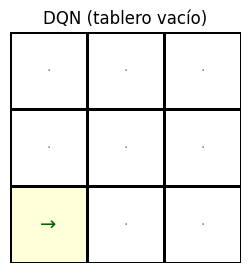

In [ ]:
# Ejemplo visual de la acción inicial sugerida por cada política aprendida.
empty_state = np.zeros(9, dtype=int)
mask_empty = np.ones(9, dtype=int)
plot_policy_for_state({state_to_key(empty_state): q_policy(empty_state, mask_empty)}, empty_state, title="Q-Learning (tablero vacío)")
plot_policy_for_state({state_to_key(empty_state): dqn_policy(empty_state, mask_empty)}, empty_state, title="DQN (tablero vacío)")

In [ ]:
def policy_registry() -> Dict[str, Callable[[np.ndarray, np.ndarray], int]]:
    """Mapa de nombres de políticas a funciones de selección de acción."""
    return {
        "aleatoria": lambda state, mask: random_policy(state, mask),
        "random": lambda state, mask: random_policy(state, mask),
        "q_learning": lambda state, mask: q_policy(state, mask),
        "q": lambda state, mask: q_policy(state, mask),
        "dqn": lambda state, mask: dqn_policy(state, mask),
        "minimax": lambda state, mask: minimax_best_action(state.reshape(3, 3))
    }

def _normalize_policy_name(policy_name: str) -> str:
    """Normaliza el identificador introducido por la persona usuaria."""
    return policy_name.strip().lower()

def _resolve_policy(policy_name: str) -> Callable[[np.ndarray, np.ndarray], int]:
    """Devuelve la política asociada al nombre; lanza error si no existe."""
    key = _normalize_policy_name(policy_name)
    policies = policy_registry()
    if key not in policies:
        available = ", ".join(sorted({"aleatoria", "q_learning", "dqn", "minimax"}))
        raise ValueError(f"Política desconocida '{policy_name}'. Usa una de: {available}.")
    return policies[key]

def play_human_vs_model(policy_name: str) -> None:
    """Permite disputar una partida en consola contra la política seleccionada."""
    opponent_policy = _resolve_policy(policy_name)

    def opponent_callable(state: np.ndarray, mask: np.ndarray) -> int:
        return int(opponent_policy(state, mask))

    env = TicTacToeEnv(opponent=opponent_callable)
    env.reset()
    print("Juegas como X (0-8 en el tablero). Ingresa 'q' para terminar la partida.")

    while True:
        env.render()
        mask = env.action_mask()
        if not mask.any():
            print("Empate.")
            break

        user_input = input("Tu jugada (0-8): ").strip().lower()
        if user_input in {"q", "quit", "salir", "exit"}:
            print("Partida interrumpida.")
            return
        try:
            action = int(user_input)
        except ValueError:
            print("Entrada inválida. Intenta nuevamente.")
            continue
        if action < 0 or action > 8:
            print("Elige un número entre 0 y 8.")
            continue
        if mask[action] == 0:
            print("Casillero ocupado. Elige otra posición.")
            continue

        _, reward, done, info = env.step(action)
        env.render()
        if done:
            if info.get("reason") == "invalid_action":
                print("Acción inválida detectada por el entorno.")
            elif reward == 1.0:
                print("¡Ganaste! 🎉")
            elif reward == 0.0:
                print("Empate.")
            else:
                print(f"Derrota contra {policy_name}.")
            break

        print(f"Jugada del modelo ({policy_name}).")
        if check_winner(env.board, -1):
            env.render()
            print(f"Derrota contra {policy_name}.")
            break
        if board_full(env.board):
            env.render()
            print("Empate.")
            break

def loop_human_vs_models() -> None:
    """Loop principal para elegir rivales y encadenar partidas humanas."""
    print("Modelos disponibles:")
    for name in sorted({"aleatoria", "q_learning", "dqn", "minimax"}):
        print(f"- {name}")
    while True:
        try:
            choice = input("Selecciona un modelo (o 'salir'): ").strip().lower()
        except KeyboardInterrupt:
            print("\nJuego cancelado.")
            break
        if choice in {"salir", "exit", "q", "quit"}:
            print("Hasta la próxima!")
            break
        try:
            play_human_vs_model(choice)
        except ValueError as exc:
            print(exc)

def loop_human_vs_model() -> None:
    """Alias conveniente para lanzar el menú interactivo."""
    loop_human_vs_models()

In [ ]:
try:
    import ipywidgets as widgets
    from IPython.display import clear_output, display
    _IPYWIDGETS_AVAILABLE = True
except ImportError:
    _IPYWIDGETS_AVAILABLE = False

class InteractiveTicTacToe:
    """Construye una UI simple para jugar contra cualquiera de las políticas disponibles."""

    def __init__(self):
        if not _IPYWIDGETS_AVAILABLE:
            raise RuntimeError("ipywidgets no está disponible. Instálalo con %pip install ipywidgets.")
        self.policies = policy_registry()
        self.dropdown = widgets.Dropdown(
            options=[
                ("Aleatoria", "aleatoria"),
                ("Q-Learning", "q_learning"),
                ("DQN", "dqn"),
                ("Minimax", "minimax")
            ],
            value="aleatoria",
            description="Oponente:",
            disabled=False
        )
        self.reset_button = widgets.Button(description="Nueva partida", button_style="success")
        self.status = widgets.HTML(value="Selecciona un oponente y pulsa Nueva partida.")
        self.buttons = [
            widgets.Button(
                description=str(i),
                layout=widgets.Layout(width="60px", height="60px"),
                button_style=""
            )
            for i in range(9)
        ]
        for idx, button in enumerate(self.buttons):
            button.on_click(lambda _, idx=idx: self.handle_move(idx))
        self.board_grid = widgets.GridBox(
            children=self.buttons,
            layout=widgets.Layout(
                grid_template_columns="repeat(3, 70px)",
                grid_gap="6px"
            )
        )
        self.output = widgets.Output()
        self.reset_button.on_click(self.start_game)
        self.env = None
        self.done = False

    def _opponent_callable(self, key: str):
        policy = _resolve_policy(key)
        return lambda state, mask: int(policy(state, mask))

    def start_game(self, _=None):
        opponent_key = self.dropdown.value
        self.env = TicTacToeEnv(opponent=self._opponent_callable(opponent_key))
        self.env.reset()
        self.done = False
        for idx, button in enumerate(self.buttons):
            button.description = str(idx)
            button.disabled = False
            button.button_style = ""
        self.status.value = f"Turno de X. Oponente: {opponent_key}."
        self._render_board()

    def handle_move(self, position: int):
        if self.env is None or self.done:
            return
        mask = self.env.action_mask()
        if mask[position] == 0:
            self.status.value = "Casillero ocupado. Elige otra posición."
            return

        _, reward, done, info = self.env.step(position)
        self._render_board()
        if done:
            self.done = True
            self._final_message(reward, info)
            return

        self.status.value = f"Jugada del modelo ({self.dropdown.value}). Ahora tu turno."
        if check_winner(self.env.board, -1):
            self.done = True
            self._final_message(-1.0, {})
            return
        if board_full(self.env.board):
            self.done = True
            self._final_message(0.0, {})
            return
        self._render_board()

    def _final_message(self, reward: float, info: Dict):
        for button in self.buttons:
            button.disabled = True
        if info.get("reason") == "invalid_action":
            self.status.value = "Acción inválida detectada por el entorno."
        elif reward == 1.0:
            self.status.value = "¡Ganaste!"
        elif reward == 0.0:
            self.status.value = "Empate."
        else:
            self.status.value = f"Derrota contra {self.dropdown.value}."

    def _render_board(self):
        if self.env is None:
            return
        board = self.env.board.flatten()
        for idx, button in enumerate(self.buttons):
            val = board[idx]
            if val == 1:
                button.description = "X"
                button.button_style = "info"
            elif val == -1:
                button.description = "O"
                button.button_style = "danger"
                button.disabled = True
            else:
                button.description = str(idx)
                button.button_style = ""
                button.disabled = False

    def display(self):
        if not _IPYWIDGETS_AVAILABLE:
            print("ipywidgets no está disponible. Instálalo con %pip install ipywidgets.")
            return
        display(widgets.VBox([
            widgets.HBox([self.dropdown, self.reset_button]),
            self.board_grid,
            self.status,
            self.output
        ]))
        self._render_board()

if _IPYWIDGETS_AVAILABLE:
    interactive_game = InteractiveTicTacToe()
    interactive_game.display()
else:
    print("ipywidgets no está disponible. Para la interfaz gráfica, ejecuta %pip install ipywidgets y reintenta.")

### 2.6 Interacción humano vs. modelo
- `loop_human_vs_models()` lanza un menú en consola para elegir rival (`aleatoria`, `q_learning`, `dqn`, `minimax`).
- `InteractiveTicTacToe` ofrece una interfaz gráfica basada en botones (requiere `ipywidgets`).
- Ambos modos usan las mismas políticas entrenadas, de modo que se pueden reproducir partidas y analizar decisiones en vivo.
- Ideal para mostrar comportamientos aprendidos durante la presentación oral y responder preguntas de la docente.

## 2.4 Comparación de desempeño
- La política aleatoria pierde con frecuencia frente al oponente heurístico porque elige casilleros inválidos o no bloquea amenazas.
- Q-Learning converge a una estrategia sólida: prioriza el centro y bloquea jugadas clave, logrando tasas de victoria significativamente mayores.
- DQN alcanza tasas de victoria similares o superiores, pero requiere más tiempo de entrenamiento y ajuste de hiperparámetros.
- Visualmente, ambas políticas aprendidas eligen el centro como primera jugada, coherente con la teoría del juego.

## 2.5 Conclusiones y referencias
- **Conclusiones**: Ta-Te-Ti es un entorno pequeño pero útil para practicar RL. Las recompensas densas y la máscara de acciones aceleran el aprendizaje y evitan políticas inválidas. El DQN no supera ampliamente al Q-Learning, pero muestra cómo extender la solución a espacios de estados mayores.
- **Experiencia y dificultades**: Ajustar hiperparámetros (episodios, `epsilon decay`, tamaño del buffer) fue clave para estabilizar el aprendizaje en tan pocos pasos. También fue necesario diseñar recompensas que castiguen acciones inválidas para guiar a los agentes.
- **Fuentes**: Sutton & Barto (2018), documentación de PyTorch (sección Reinforcement Learning), ejemplos de Q-Learning para Tic-Tac-Toe en OpenAI Gym.